# Loading packages and function codes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
def read_aquacrop_output(file_path, columns):
    """Reads AquaCrop .OUT files and returns a combined DataFrame"""
    with open(file_path,encoding='latin-1') as file:
        lines = file.readlines()

    runs = []
    current_run = []

    for line in lines:
        if line.startswith('** Run number:'):
            if current_run:
                runs.append(current_run)
                current_run = []
        elif line.strip() and not line.startswith(('Day', 'AquaCrop', 'Soil', 'mm', 'm')) and not line.startswith('   -'):
            parts = line.split()
            if len(parts) >= 5:  # Ensure it's a data line
                current_run.append(parts)

    if current_run:
        runs.append(current_run)

    dfs = []
    for i, run_data in enumerate(runs, 1):
        if not run_data:
            continue

        # Create DataFrame and handle column count mismatch
        df = pd.DataFrame(run_data)
        col_count = min(len(columns), df.shape[1])
        df.columns = columns[:col_count]

        # Convert numeric columns
        for col in df.columns:
            if col != 'Stage':  # Stage could be text
                df[col] = pd.to_numeric(df[col], errors='coerce')

        df['Run'] = i
        dfs.append(df)

    return pd.concat(dfs) if dfs else None

def plot_variable(df, variable, plot_title=None, y_label=None, figsize=(8, 5)):#change the figure size as desired. for example try (10,7)
    """Plots a variable across all seasons"""
    if df is None:
        print("No data available to plot.")
        return

    plt.figure(figsize=figsize)

    for run_num in df['Run'].unique():
        run_data = df[df['Run'] == run_num]
        plt.plot(run_data['DAP'], run_data[variable], label=f'Season {run_num}')

    plt.xlabel('Days After Sowing (DAP)')
    plt.ylabel(y_label or f'{variable}')
    plt.title(plot_title or f'{variable} Over Time for Each Season')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_multiple_variables(df, run_num, variables, plot_title=None, y_label=None, figsize=(8, 5)):
    """Plots multiple variables for a single season"""
    if df is None:
        print("No data available to plot.")
        return

    plt.figure(figsize=figsize)
    run_data = df[df['Run'] == run_num]

    for var in variables:
        if var in run_data.columns:
            plt.plot(run_data['DAP'], run_data[var], label=var)

    plt.xlabel('Days After Sowing (DAP)')
    plt.ylabel(y_label or 'Value')
    plt.title(plot_title or f'Multiple Variables - Season {run_num}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example 1: Water balance components for single or multiple cropping seasons

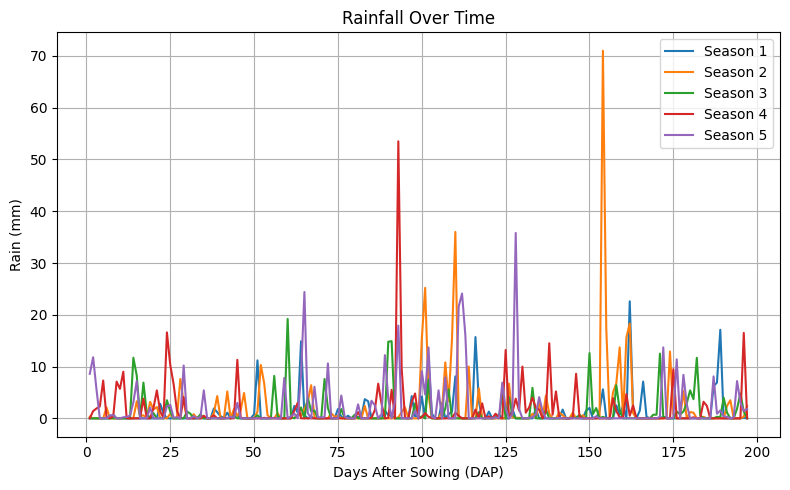

In [ ]:
wabal_columns = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'WCTot', 'Rain', 'Irri', 'Surf',
                'Infilt', 'RO', 'Drain', 'CR', 'Zgwt', 'Ex', 'E', 'E/Ex', 'Trx', 'Tr',
                'Tr/Trx', 'ETx', 'ET', 'ET/ETx']
wabal_df = read_aquacrop_output('https://github.com/AdeBIrk/AquaCropvis/blob/6d0ae90b6ccc6058f9094db19796267b461e6ac4/Example_Wabal.OUT', wabal_columns) # Replace the file path ending with Wabal.OUT
plot_variable(wabal_df, 'Rain', 'Rainfall Over Time', 'Rain (mm)')

# LEGEND
# DAP          : Days after planting
# Stage        : 0: before/after planting
# Stage        : 1: emergence or transplant recovery
# Stage        : 2: vegetative stage
# Stage        : 3: flowering
# Stage        : 4: yield formation and ripening
# WCTot        : Water content in total soil profile
# Rain         : Rainfall
# Irri         : Water applied by irrigation
# Surf         : Stored water on soil surface between bunds
# Infilt       : Infiltrated water in soil profile
# RO           : Surface runoff
# Drain        : Water drained out of the soil profile
# CR           : Water moved upward by capillary rise
# Zgwt         : Depth of the groundwater table (-9.90 if absent)
# Ex           : Maximum soil evaporation
# E            : Soil evaporation
# E/Ex         : Relative soil evaporation (100 E/Ex)
# Trx          : Maximum crop transpiration
# Tr           : Total transpiration of crop and weeds
# Tr/Trx       : Relative transpiration (100 Tr/Trx)
# ETx          : Evapotranspiration maximale
# ET           : Evapotranspiration
# ET/ETx       : Evapotranspiration relative (100 ET/ETx)

# Example 2: Soil Water Content at a specific layer for single or multiple cropping seasons

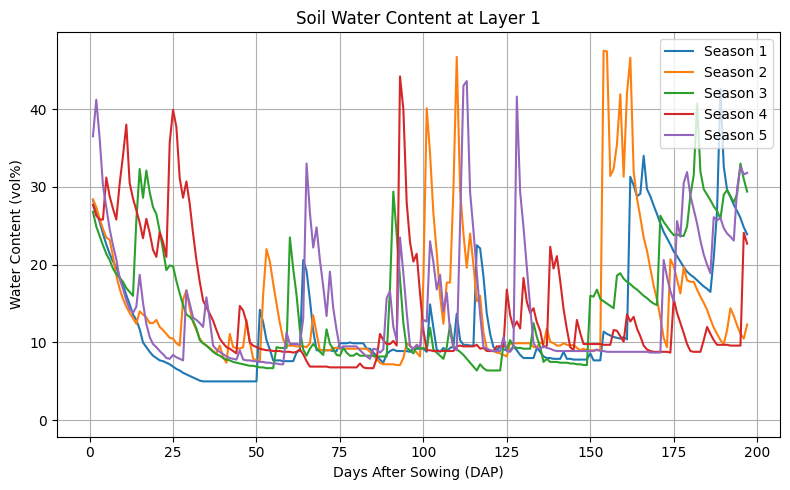

In [ ]:
wc_columns = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'WC1(vol%)', 'WC2(vol%)', 'WC3(vol%)',
             'WC4(vol%)', 'WC5(vol%)', 'WC6(vol%)', 'WC7(vol%)', 'WC8(vol%)', 'WC9(vol%)',
             'WC10(vol%)', 'WC11(vol%)', 'WC12(vol%)']
wc_df = read_aquacrop_output('https://github.com/AdeBIrk/AquaCropvis/blob/6d0ae90b6ccc6058f9094db19796267b461e6ac4/Example_CompWC.OUT', wc_columns)# Replace the file path ending with CompWC.OUT
plot_variable(wc_df, 'WC1(vol%)', 'Soil Water Content at Layer 1', 'Water Content (vol%)')

##  LEGEND
# DAP          : Days after planting
# Stage        : 0: before/after planting
# Stage        : 1: emergence or transplant recovery
# Stage        : 2: vegetative stage
# Stage        : 3: flowering
# Stage        : 4: yield formation and ripening
# WC1(vol%) - WC12(vol%) : Water Content (WC) at different soil layers (1,2,3,4,5.....)

# Example 4 - Soil water content comparison at multiple soil layers per one cropping season

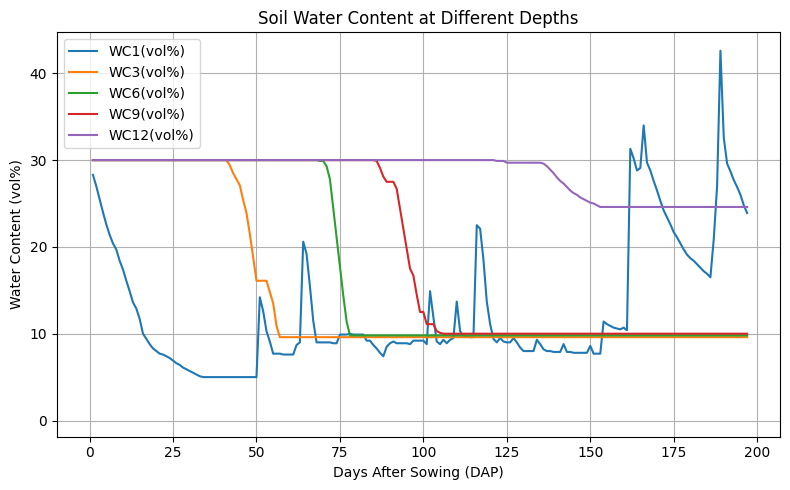

In [ ]:

soil_layers = ['WC1(vol%)', 'WC3(vol%)', 'WC6(vol%)', 'WC9(vol%)', 'WC12(vol%)']
plot_multiple_variables(wc_df, 1, soil_layers, 'Soil Water Content at Different Depths', 'Water Content (vol%)')

# Example 5: Crop growth outputs for single or multiple seasons

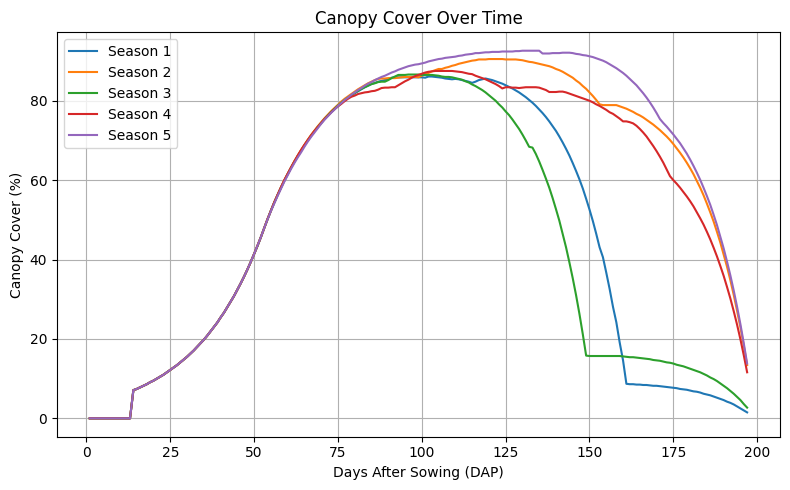

In [ ]:

crop_columns = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'GD', 'Z', 'StExp', 'StSto', 'StSen',
               'StSalt', 'StWeed', 'CC', 'CCw', 'StTr', 'Kc(Tr)', 'Trx', 'Tr', 'TrW', 'Tr/Trx',
               'WP', 'Biomass', 'HI', 'YieldPart', 'Brelative', 'WPet']
crop_df = read_aquacrop_output('https://github.com/AdeBIrk/AquaCropvis/blob/6d0ae90b6ccc6058f9094db19796267b461e6ac4/Example_Crop.OUT', crop_columns)# Replace the file path ending with Crop.OUT
plot_variable(crop_df, 'CC', 'Canopy Cover Over Time', 'Canopy Cover (%)')

# Legend

# DAP          : Days after planting
# Stage        : 0: before/after planting
# Stage        : 1: emergence or transplant recovery
# Stage        : 2: vegetative stage
# Stage        : 3: flowering
# Stage        : 4: yield formation and ripening
# GD           : Growing degrees
# Z            : Effective rooting depth
# StExp        : Percent water stress reducing leaf expansion
# StSto        : Percent water stress inducing stomatal closure
# StSen        : Percent water stress triggering early canopy senescence
# StSalt       : Percent salinity stress
# StWeed       : Relative cover of weeds
# CC           : Green total Canopy Cover of crop and weeds
# CCw          : Green crop Canopy Cover in weed infested field
# StTr         : Percent temperature stress affecting crop transpiration
# Kc(Tr)       : Crop coefficient for transpiration
# Trx          : Maximum total transpiration of crop and weeds
# Tr           : Total transpiration of crop and weeds
# TrW          : Crop transpiration in weed infested field
# Tr/Trx       : Relative total transpiration of crop and weeds (100 Tr/Trx)
# WP           : Crop water productivity adjusted for CO2, soil fertility and products synthesized
# Biomass      : Cumulative crop biomass
# HI           : Harvest Index adjusted for failure of pollination, inadequate photosynthesis and water stress
# Yield Part   : Crop yield (HI x Biomass)
# Brelative    : Relative biomass (Reference: no water, no soil fertility, no soil salinity stress, no weed infestation)
# WPet         : ET Water productivity for yield part (kg yield produced per m3 water evapotranspired)

# Example 6: Water content in total soil profile for single or multiple seasons

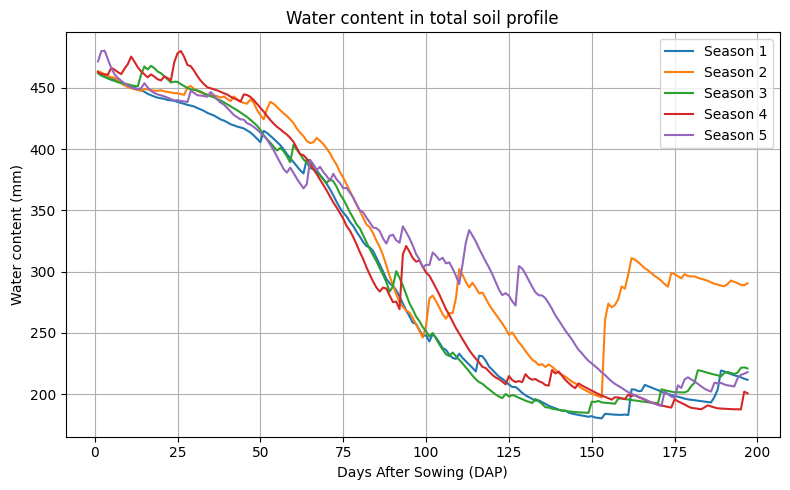

In [ ]:

prof_columns = ['Day', 'Month', 'Year', 'DAP', 'Stage', 'WCTot', 'Wr(Zx)',
           'Z', 'Wr', 'Wr(SAT)', 'Wr(FC)', 'Wr(exp)', 'Wr(sto)',
           'Wr(sen)', 'Wr(PWP)']
prof_df = read_aquacrop_output('https://github.com/AdeBIrk/AquaCropvis/blob/6d0ae90b6ccc6058f9094db19796267b461e6ac4/Example_Prof.OUT', prof_columns) # Replace the file path ending with Prof.OUT
plot_variable(prof_df, 'WCTot', 'Water content in total soil profile', 'Water content (mm)')

# Legend

# DAP          : Days after planting
# Stage        : 0: before/after planting
# Stage        : 1: emergence or transplant recovery
# Stage        : 2: vegetative stage
# Stage        : 3: flowering
# Stage        : 4: yield formation and ripening
# WCTot        : Water content in total soil profile (layer: 0.00 - 1.55 m)
# Wr(Zx)       : Water content in maximum effective root zone (Zx = 1.50 m)
# Z            : Effective rooting depth
# Wr           : Water content in effective root zone
# Wr(Sat)      : Water content in effective root zone if saturated
# Wr(FC)       : Water content in effective root zone at field capacity
# Wr(exp)      : Water content in effective root zone at upper threshold for leaf expansion
# Wr(sto)      : Water content in effective root zone at upper threshold for stomatal closure
# Wr(sen)      : Water content in effective root zone at upper threshold for early canopy senescence
# Wr(PWP)      : Water content in effective root zone at permanent wilting point